In [ ]:
pip install preliz

In [2]:
import preliz as pz

In [70]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
import pandas as pd

#**How Many Goals Are Scored In A Soccer Game In The Premier League - On Average**

## Intro:

Soccer is notoriously known as being a low scoring game. Many refuse to watch soccer because "the score ends up 1 - 0 or 0 - 0 usually". Because of this, I want to find the average amount of goals scored in a soccer game (taken from Premier League data) to prove everyone wrong (or right).

For those unaware of how league soccer works, it functions similar to any other sport. For the Premier League, the first division league for English Soccer Clubs, each club plays 38 games across the year against 19 different opponents, playing each opponent twice. Once on their home turf and once on their opponent's stadium.

Whoever scores more goals ends up with more points, driving teams to score.



## Setting the Likelihood :

I'll be pulling data from the Premier League, the top-division soccer league in England. From the past season, the 2023/2024 season, 380 games have been played, making it a good pool of data to pull from. After this, I'll compile a histogram.

In [71]:
data_goals = pd.read_csv('https://raw.githubusercontent.com/AbdurSharif/data-science-1/refs/heads/main/premgoals.csv')
data_goals

,3
0,6
1,2
2,3
3,3
4,5
...,...
374,1
375,6
376,4
377,2


(array([11., 44., 78., 81., 81., 48., 23., 10.,  2.,  1.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

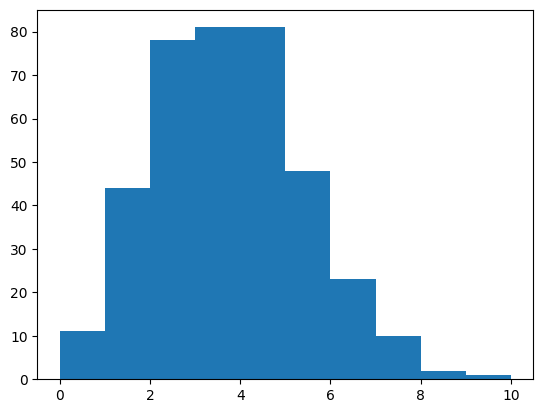

In [72]:
plt.hist(data_goals)


This looks approximately normal! I think due to so many data points (380), making it well above the minimum 30 you need to assume normality, the curve was able to become so close to normal.

In [73]:
with pm.Model() as model_goals:
    # avg goals seems to be peaking between 3 and 5
    μ = pm.Uniform('μ', lower=3, upper=5)

    #Looks like a standard normal distribution, sigma=5 was already here so why not use it!
    σ = pm.Normal('σ', sigma=5)

    #likelihood + priors
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=data_goals)
    idata_goals = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

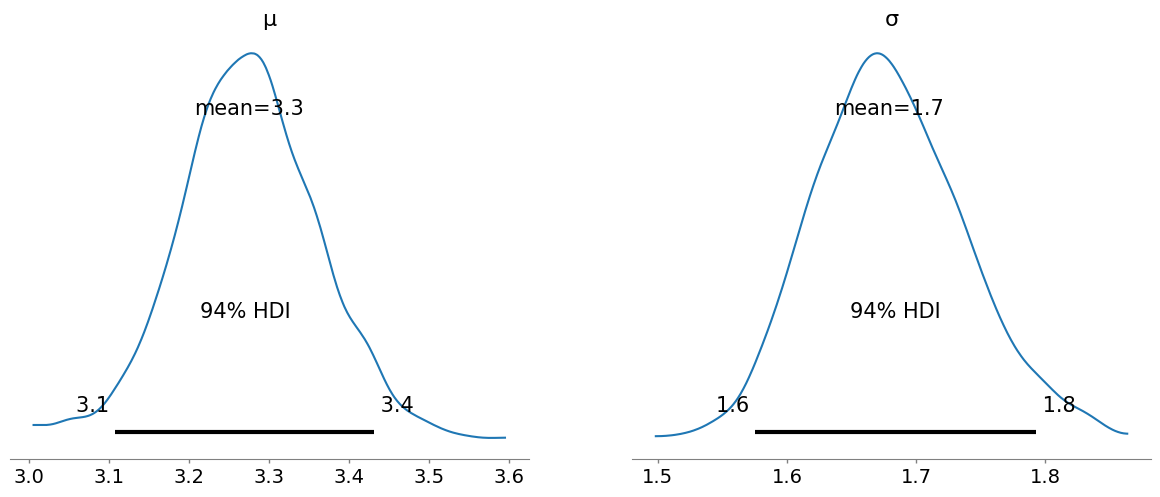

In [74]:
az.plot_posterior(idata_goals)

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

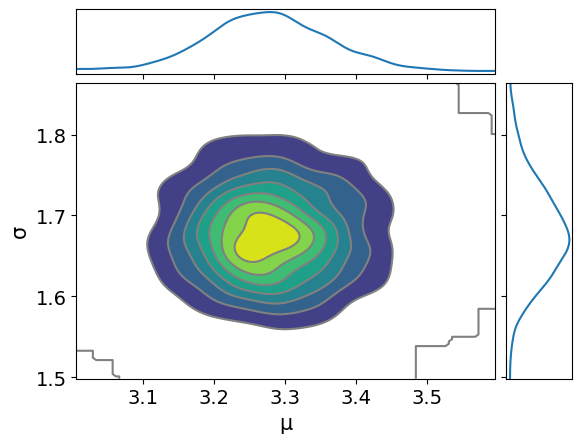

In [75]:
az.plot_pair(idata_goals, kind='kde', marginals=True)

In [76]:
pm.sample_posterior_predictive(idata_goals, model=model_goals, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

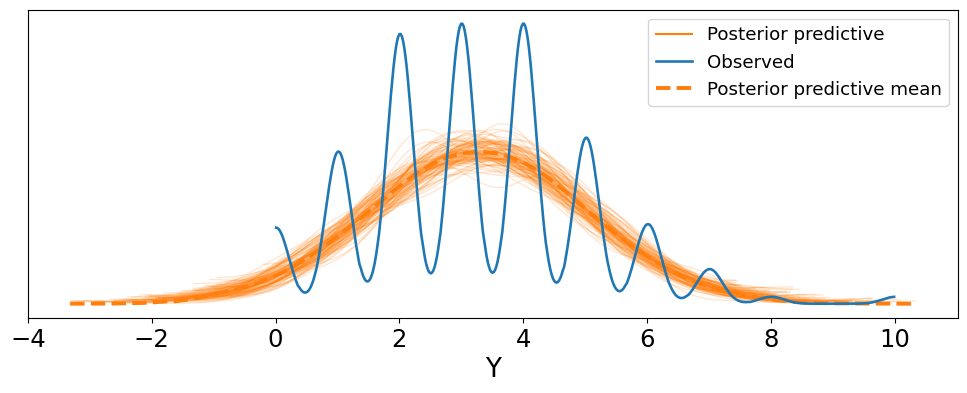

In [77]:
az.plot_ppc(idata_goals, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

## Yikes...

So it looks like a sine wave? I'm not gonna lie, I don't remember this from the notes. Maybe I'll try playing around witht the values. I know I arbitrarily decided 5 was a good sigma value, so maybe that's causing it. Let's start with testing with sigma = 1 as a baseline.  

In [78]:
with pm.Model() as model_goals:
    # avg goals seems to be peaking between 3 and 5
    μ = pm.Uniform('μ', lower=3, upper=5)

    #Testing with sigma = 1
    σ = pm.Normal('σ', sigma=1)

    #likelihood + priors
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=data_goals)
    idata_goals = pm.sample()

Output()

Output()

In [79]:
pm.sample_posterior_predictive(idata_goals, model=model_goals, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

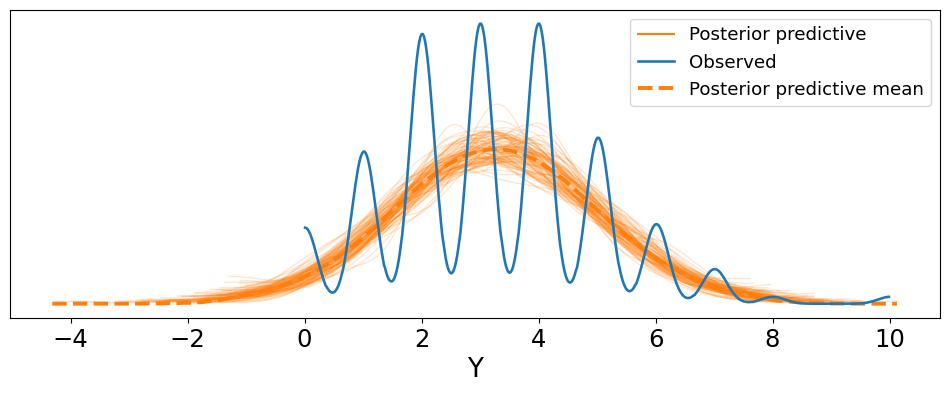

In [80]:
az.plot_ppc(idata_goals, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

## Let's Try Again

Ok lets make sure its not because the sigma value is too low real quick, but I don't think thats the reason why the graph is doing this. This graph looks identical to the original observed graph. This time lets set the sigma value to 100. That should be enough

In [81]:
with pm.Model() as model_goals:
    # avg goals seems to be peaking between 3 and 5
    μ = pm.Uniform('μ', lower=3, upper=5)

    #testing with sigma = 100
    σ = pm.Normal('σ', sigma=100)

    #likelihood + priors
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=data_goals)
    idata_goals = pm.sample()

Output()

Output()

In [82]:
pm.sample_posterior_predictive(idata_goals, model=model_goals, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

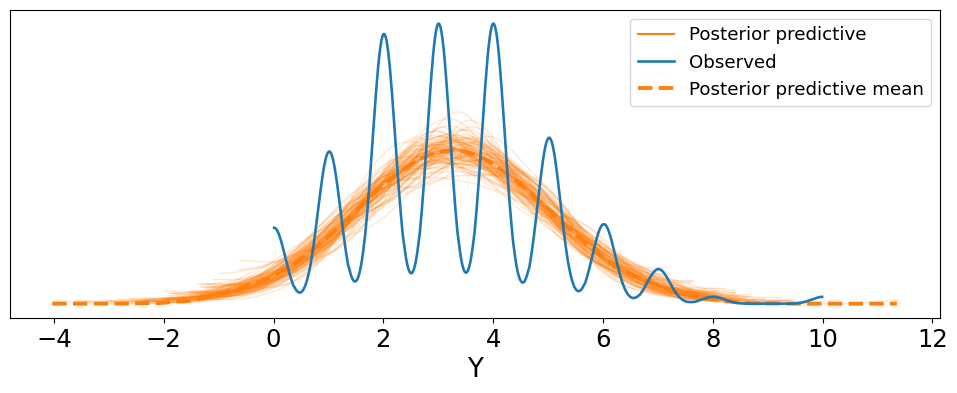

In [83]:
az.plot_ppc(idata_goals, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

## Huge Realization

So I've been wasting my time. I've just clocked in (thanks to my good friend Yeshi) that the reason why it looks so wavy is because my data is **discrete**. At the 1, 2, 3, etc marks exactly is where the data spikes. Obviously I need a discrete distribution to pair with my data. I'll try the Poisson distribution first.

In [84]:
with pm.Model() as model_goals:
#changed the paramenters because I overestimated the mean.
    μ = pm.Uniform('μ', lower=3, upper=5)

    Y = pm.Poisson('Y',mu=μ,observed=data_goals)
    idata_goals = pm.sample()

Output()

Output()

In [85]:
pm.sample_posterior_predictive(idata_goals, model=model_goals, extend_inferencedata=True)


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

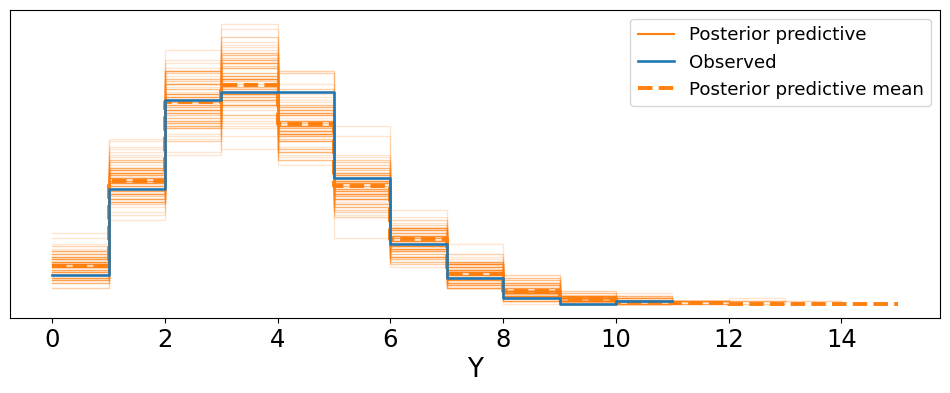

In [86]:
az.plot_ppc(idata_goals, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

## It's solved!

Luck was on my side today. The Poisson distribution seems to match the Posterior Predictive mean pretty well!

I believe the Poisson distribution matching the data makes sense, as the distribution is a good curve to model discrete data that occurs over a fixed interval of time or space. The events (goals) should be assummed to be independent of one another and occur with a constant average rate. The fixed interval of time is the 90 minutes a soccer match lasts for, or one game.

Analyzing the model, we see the posterior predictive curves having lots of variation at lower goal amounts, while appearing tighter near the 8 - 10 goals range. This tells us that the Poisson model has trouble predicting when teams are evenly matched, while has ease predicting the amount of goals when there is a blowout. For example, when two top teams like Manchester City and Arsenal, there is much uncertaincy whether both teams will score and even amount, or if they'll stay in a 0 - 0 deadlock. In there last two matchups in the Premier League, the result was 0 - 0, totaling 0 goals, and 2 - 2, resulting in a whopping 4 goals. For matches like these, the Poisson distribution can't predict the result of that accurately, so there are lots of variation around those areas. In a blowout however, like the first place team vs. the last place team, the model can be confident in a high scoring game. 6 - 0, 7 - 1, etc. are all probable outcomes the model can predict. For such a little amount of predicted high scoring games, it's clear the level of quality between the teams isn't astronomical within the premier league, and so it could be interesting comparing games that take place between lower quality leagues and higher qaulity leagues.

With a mean of around 3 - 5 goals per soccer game, I believe I've disproven the theory about how most soccer games end 0 - 0 or 1 - 0, but it does show the sport's tendency be unpredictable in whether a game could be low scoring or high scoring.



